# Fine-Tuning the Text to Image Model

Let's teach our text to image generator what my dog looks like.

![redhat dog](https://rhods-public.s3.amazonaws.com/sample-data/images/redhat-dog-small.jpg)

### Check GPU

**It's recommended that you shut down any other notebook kernels.**

This fine tuning process uses a lot of video memory.   Here, we'll check on how much we have available.

In [1]:
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

NVIDIA A10G, 23028 MiB, 22502 MiB


## Install Requirements

In [2]:
!pip install -r requirements.txt

  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-6qe7xkge
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-6qe7xkge
  Resolved https://github.com/huggingface/diffusers to commit 42cae93b942ec904ead46c26c42be24422adc92c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 102.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 272.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 218.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 MB 229.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 240.9 MB/s eta 0:00:00a 0:00:

In [3]:
!pip list | grep -E "boto|grpcio|pandas|torch|torchvision|diffusers|transformers|accelerate|flash-attn|ftfy|xformers|protobuf"

accelerate                0.28.0
boto3                     1.34.89
botocore                  1.34.89
codeflare-torchx          0.6.0.dev2
diffusers                 0.29.0.dev0
flash-attn                2.5.9.post1
ftfy                      6.2.0
grpcio                    1.64.0
grpcio-tools              1.64.0
pandas                    2.2.2
protobuf                  5.27.0
torch                     2.2.2+cu121
torchvision               0.17.2+cu121
transformers              4.39.3
xformers                  0.0.25.post1

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Settings

Here we set up all the options for training.  Most are environment variables which will allow us to override values from pipelines and run this notebook with different setting such as the base model or number of training steps and learning rate.

In [4]:
import os
from datetime import datetime

date = datetime.now()
date_string = date.strftime("%Y%m%d%H%M%S")

VERSION = os.environ.get("VERSION", f"notebook-output")
MODEL_NAME = os.environ.get("MODEL_NAME", "runwayml/stable-diffusion-v1-5")
OUTPUT_DIR = os.path.join(os.getcwd(), f"{VERSION}/stable_diffusion_weights/redhat-dog")
DATA_DIR = os.path.join(os.getcwd(), f"{VERSION}/data")
INSTANCE_DATA_URL = os.environ.get("INSTANCE_DATA_URL", "https://rhods-public.s3.amazonaws.com/sample-data/images/redhat-dog.tar.gz")
INSTANCE_DIR = os.path.join(DATA_DIR, "instance_dir")
CLASS_DIR = os.path.join(DATA_DIR, "class_dir")
INSTANCE_PROMPT = os.environ.get("INSTANCE_PROMPT", "photo of a rhteddy dog")
CLASS_PROMPT = os.environ.get("CLASS_PROMPT", "a photo of dog")

NUM_CLASS_IMAGES = int(os.environ.get("NUM_CLASS_IMAGES", "200"))
MAX_TRAIN_STEPS = int(os.environ.get("MAX_TRAIN_STEPS", "800"))

ONNX_OUTPUT_DIR = os.path.join(os.getcwd(), f"{VERSION}/onnx-redhat-dog")

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(INSTANCE_DIR, exist_ok=True)

print(f"Weights will be saved at {OUTPUT_DIR}")
print(f"It will be based on the model {MODEL_NAME}")
print(f"Training data located in downloaded from {INSTANCE_DATA_URL}")
print(f"We're going to train the difference between \"{INSTANCE_PROMPT}\" and \"{CLASS_PROMPT}\"")


Weights will be saved at /opt/app-root/src/openshift-ai-text-to-image-demo/notebook-output/stable_diffusion_weights/redhat-dog
It will be based on the model runwayml/stable-diffusion-v1-5
Training data located in downloaded from https://rhods-public.s3.amazonaws.com/sample-data/images/redhat-dog.tar.gz
We're going to train the difference between "photo of a rhteddy dog" and "a photo of dog"


## Training

### Get Training Data


In [5]:
import sys
import os
import tarfile
import urllib

url = INSTANCE_DATA_URL
output = f"instance-images.tar.gz"
urllib.request.urlretrieve(url, output)

!tar -xzf instance-images.tar.gz -C $INSTANCE_DIR

### Set up the Training Job

In [6]:
!accelerate config default

accelerate configuration saved at /opt/app-root/src/.cache/huggingface/accelerate/default_config.yaml


In [7]:
!wget -O train_dreambooth.py https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth.py

--2024-05-30 03:14:10--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58466 (57K) [text/plain]
Saving to: ‘train_dreambooth.py’

train_dreambooth.py 100%[===================>]  57.10K  --.-KB/s    in 0.003s  

2024-05-30 03:14:10 (21.4 MB/s) - ‘train_dreambooth.py’ saved [58466/58466]



### Start Training

Here we kick off the training job with our chosen settings.  This will take about 15 minutes depending on settings and hardware.

In [8]:
!echo "MODEL_NAME=$MODEL_NAME"
!echo "OUTPUT_DIR=$OUTPUT_DIR"
!echo "DATA_DIR=$DATA_DIR"
!echo "INSTANCE_DIR=$INSTANCE_DIR"
!echo "CLASS_DATA_URL=$CLASS_DATA_URL"
!echo "CLASS_DIR=$CLASS_DIR"
!echo "INSTANCE_PROMPT=$INSTANCE_PROMPT"
!echo "CLASS_PROMPT=$CLASS_PROMPT"
!echo "NUM_CLASS_IMAGES=$NUM_CLASS_IMAGES"
!echo "MAX_TRAIN_STEPS=$MAX_TRAIN_STEPS"

MODEL_NAME=runwayml/stable-diffusion-v1-5
OUTPUT_DIR=/opt/app-root/src/openshift-ai-text-to-image-demo/notebook-output/stable_diffusion_weights/redhat-dog
DATA_DIR=/opt/app-root/src/openshift-ai-text-to-image-demo/notebook-output/data
INSTANCE_DIR=/opt/app-root/src/openshift-ai-text-to-image-demo/notebook-output/data/instance_dir
CLASS_DATA_URL=
CLASS_DIR=/opt/app-root/src/openshift-ai-text-to-image-demo/notebook-output/data/class_dir
INSTANCE_PROMPT=photo of a rhteddy dog
CLASS_PROMPT=a photo of dog
NUM_CLASS_IMAGES=200
MAX_TRAIN_STEPS=800


In [12]:
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --with_prior_preservation \
  --prior_loss_weight=1.0 \
  --instance_prompt="$INSTANCE_PROMPT" \
  --class_prompt="$CLASS_PROMPT" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=2 \
  --gradient_checkpointing \
  --use_8bit_adam \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=$NUM_CLASS_IMAGES \
  --max_train_steps=$MAX_TRAIN_STEPS \
  --enable_xformers_memory_efficient_attention

05/30/2024 03:26:54 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

/opt/app-root/lib64/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'rescale_betas_zero_snr', 'dynamic_thresholding_ratio', 'thresholding', 'prediction_type', 'timestep_spacing', 'clip_sample_range', 'variance_type', 'sample_max_value'} was not found in config. Values will be initialized to default values.
{'scaling_factor', 'latents_mean', 'force_upcast', 'latents_std'} was not found in config. Values will be initialized to default values.
{'class_embed

### Examine the output

If everything went well, we should have generated model weights in the `$OUTPUT_DIR` including those for the tokenizer, vae, unet, and text encoder.  You could now load these weights and generate images with our finetuned model.  You could simply replace any references to our Huggingface model (`runwayml/stable-diffusion-v1-5`) with the path to our new weights (e.g. `./notebook-output/stable_diffusion_weights/redhat-dog`)

It's also ready for upload to Huggingface, such as [cfchase/stable-diffusion-rhteddy](https://huggingface.co/cfchase/stable-diffusion-rhteddy), where you can use those weights in another notebook or application.  To try out the custom weight from huggingface (or any other weights) with multiple images generated, try the notebook [misc-notebooks/generate_multiple.ipynb](misc-notebooks/generate_multiple.ipynb).

In [13]:
!ls $OUTPUT_DIR

checkpoint-500	   logs		     safety_checker  text_encoder  unet
feature_extractor  model_index.json  scheduler	     tokenizer	   vae


In [14]:
import torch
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained(OUTPUT_DIR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipeline.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.29.0.dev0",
  "_name_or_path": "/opt/app-root/src/openshift-ai-text-to-image-demo/notebook-output/stable_diffusion_weights/redhat-dog",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/50 [00:00<?, ?it/s]

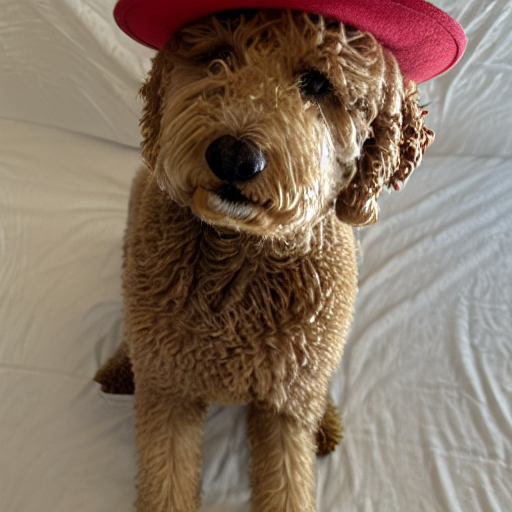

In [15]:
image = pipeline("a photo of a rhteddy dog").images[0]
image

# Export to ONNX

In order to to serve the model as an API, we need to use a format the model server understands.  The [Open Neural Network Exchange (ONNX)](https://onnx.ai/) is an open format built to represent machine learning models that enables AI developers to use models with a variety of frameworks, tools, runtimes, and compilers.  **Next we'll convert the model to ONNX using the script provided by  Huggingface [here](https://github.com/huggingface/diffusers/blob/main/scripts/convert_stable_diffusion_checkpoint_to_onnx.py).**


In [16]:
!pip install onnxruntime


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [17]:
!python convert_stable_diffusion_checkpoint_to_onnx.py --model_path "$OUTPUT_DIR" --output_path "$ONNX_OUTPUT_DIR"

Loading pipeline components...: 100%|█████████████| 7/7 [00:13<00:00,  1.97s/it]
/opt/app-root/lib64/python3.9/site-packages/transformers/modeling_attn_mask_utils.py:86: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if input_shape[-1] > 1 or self.sliding_window is not None:
/opt/app-root/lib64/python3.9/site-packages/transformers/modeling_attn_mask_utils.py:162: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if past_key_values_length > 0:
/opt/app-root/lib64/python3.9/site-packages/transformers/models/clip/modeling_clip.py:281: TracerWarning: Converting

### Did it look like Teddy?

## Save to S3

Now we have our model in a portable ONNX format, however, it's not doing much good in this notebook.  We need to push the model to our connected storage location.  Then we can use it in another notebook or serve the models for use within an application.

Note:  This requires a data connection to an S3 compatible bucket.  As part of the setup for this project, you added the [setup-s3.yaml](https://github.com/cfchase/text-to-image-demo/blob/main/setup/setup-s3.yaml) which created a local s3 bucket and data connections.

In [18]:
import os
import boto3
import botocore

aws_access_key_id = os.environ.get('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')
endpoint_url = os.environ.get('AWS_S3_ENDPOINT')
region_name = os.environ.get('AWS_DEFAULT_REGION')
bucket_name = os.environ.get('AWS_S3_BUCKET')

session = boto3.session.Session(aws_access_key_id=aws_access_key_id,
                                aws_secret_access_key=aws_secret_access_key)

s3_resource = session.resource(
    's3',
    config=botocore.client.Config(signature_version='s3v4'),
    endpoint_url=endpoint_url,
    region_name=region_name)

bucket = s3_resource.Bucket(bucket_name)


def upload_directory_to_s3(local_directory, s3_prefix):
    for root, dirs, files in os.walk(local_directory):
        for filename in files:
            file_path = os.path.join(root, filename)
            relative_path = os.path.relpath(file_path, local_directory)
            s3_key = os.path.join(s3_prefix, relative_path)
            print(f"{file_path} -> {s3_key}")
            bucket.upload_file(file_path, s3_key)


def list_objects(prefix):
    filter = bucket.objects.filter(Prefix=prefix)
    for obj in filter.all():
        print(obj.key)

In [19]:
upload_directory_to_s3(ONNX_OUTPUT_DIR, f"Stable-Diffusion-Dreambooth/")

In [20]:
list_objects(f"Stable-Diffusion-Dreambooth/")

Stable-Diffusion-Dreambooth/feature_extractor/preprocessor_config.json
Stable-Diffusion-Dreambooth/model_index.json
Stable-Diffusion-Dreambooth/safety_checker/model.onnx
Stable-Diffusion-Dreambooth/scheduler/scheduler_config.json
Stable-Diffusion-Dreambooth/text_encoder/model.onnx
Stable-Diffusion-Dreambooth/tokenizer/merges.txt
Stable-Diffusion-Dreambooth/tokenizer/special_tokens_map.json
Stable-Diffusion-Dreambooth/tokenizer/tokenizer_config.json
Stable-Diffusion-Dreambooth/tokenizer/vocab.json
Stable-Diffusion-Dreambooth/unet/model.onnx
Stable-Diffusion-Dreambooth/unet/weights.pb
Stable-Diffusion-Dreambooth/vae_decoder/model.onnx
Stable-Diffusion-Dreambooth/vae_encoder/model.onnx


### Remember the S3 Prefixes 

Take note of these s3 keys and prefixes.  We'll need to refer to them later when serving our model.  You'll need to provide the prefix up to each onnx file to download the onnx file and any adjacent files necessary.

For example, `path_to/unet/model.onnx` also requires `path_to/unet/model.onnx_data`, so we would use `path_to/unet` for serving.  By default, we'd use 4 paths for the 4 models:
```
Stable-Diffusion-Dreambooth/text_encoder
Stable-Diffusion-Dreambooth/unet
Stable-Diffusion-Dreambooth/vae_decoder
Stable-Diffusion-Dreambooth/vae_encoder

```

### Next

The next notebook [Notebook 3 - Remote Inference](3_remote_inference.ipynb), tests out Red Hat OpenShift AI Serving capabilities.  Before trying it out, you must have deployed a custom runtime for Triton, created a model server, and deployed the 4 models.